# AI in Finance Project: Buy the Close, Sell the Open

In [1]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.signal import find_peaks

In [2]:
#Silence some annoying errors
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
#Set directory
os.chdir('/Users/19052/Desktop/')

# Hypothesis

See: https://www.businessinsider.com/stocks-fall-during-regular-trading-hours-rise-overnight-2016-3 for hypothesis. The strategy here is to buy the close and sell at open next morning, the features will be 20 days of open price, close price, and volume data, as well as weekday ordinally encoded. May also add a sliding window variance feature. Target is the percent difference between next days close price, and the day after thats open price. Assuming you would need to decide a day before the trade, might also include day of open price.

# Importing Data 

In [4]:
#pulling in data, top 10 US tech stocks by market cap (omitted TSLA, because not really tech))
StackedPrices = pd.read_csv("TechStocks.csv")
StackedPrices.date = pd.to_datetime(StackedPrices.date) 
StackedPrices.PRC = abs(StackedPrices.PRC) 

#Dropping these features for now
StackedPrices = StackedPrices.drop(['PERMNO'], axis = 1)
StackedPrices = StackedPrices.drop(['BIDLO'], axis = 1)
StackedPrices = StackedPrices.drop(['ASKHI'], axis = 1) #double check what this is
StackedPrices = StackedPrices.drop(['BID'], axis = 1)
StackedPrices = StackedPrices.drop(['ASK'], axis = 1)
StackedPrices = StackedPrices.drop(['NUMTRD'], axis = 1)

#remove voting shares of Google and sorting
StackedPrices = StackedPrices[StackedPrices['TICKER'] != "GOOGL"] 
StackedPrices.sort_values(by=['TICKER', 'date'], inplace=True)

StackedPrices.head()

,date,TICKER,PRC,VOL,OPENPRC
4024,2016-01-04,AAPL,105.35,69383612,102.61
4025,2016-01-05,AAPL,102.71,55791042,105.75
4026,2016-01-06,AAPL,100.70,68487388,100.56
4027,2016-01-07,AAPL,96.45,81466204,98.68
4028,2016-01-08,AAPL,96.96,70798746,98.55


In [5]:
#useful function for unpivoting tables
def MyStack(X):
    X = X.stack(dropna=False)
    X.reset_index(inplace=True)
    X.sort_values(by=['TICKER', 'date'], inplace=True)
    return(X)

In [6]:
#list of tickers
Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']

In [7]:
#Unstacking Data
UnstackedPrices = pd.pivot_table(StackedPrices, values=['PRC','VOL', 'OPENPRC'], index=['date'], columns=['TICKER'], aggfunc=np.sum)
#UnstackedPrices.sort_index()

# Feature Engineering Part 1

In [8]:
#Adding rolling window features

#20 day rolling standard deviation
for i in Tick:
    UnstackedPrices['20STD', i] = UnstackedPrices['PRC', i].rolling(window=20).std()

#5 day rolling standard deviation
for ii in Tick:
    UnstackedPrices['5STD', ii] = UnstackedPrices['PRC', ii].rolling(window=5).std()
    
#5 day rolling mean
for iii in Tick:
    UnstackedPrices['5AVG', iii] = UnstackedPrices['PRC',iii].rolling(window=5).mean()
    
#Middle of the day feature

In [9]:
#Saving these on the side to reassemble dataframe after its converted to numpy array with scaler
col = UnstackedPrices.columns
idx = UnstackedPrices.index

#Normalizing data
scaler = StandardScaler()
X = scaler.fit_transform(UnstackedPrices)

#Reassembling Dataframe
NormPrices = pd.DataFrame(X)
NormPrices.index = idx
NormPrices.columns = col
#NormPrices.head()

In [10]:
#NormPrices.tail()

# Visualization & Exploration

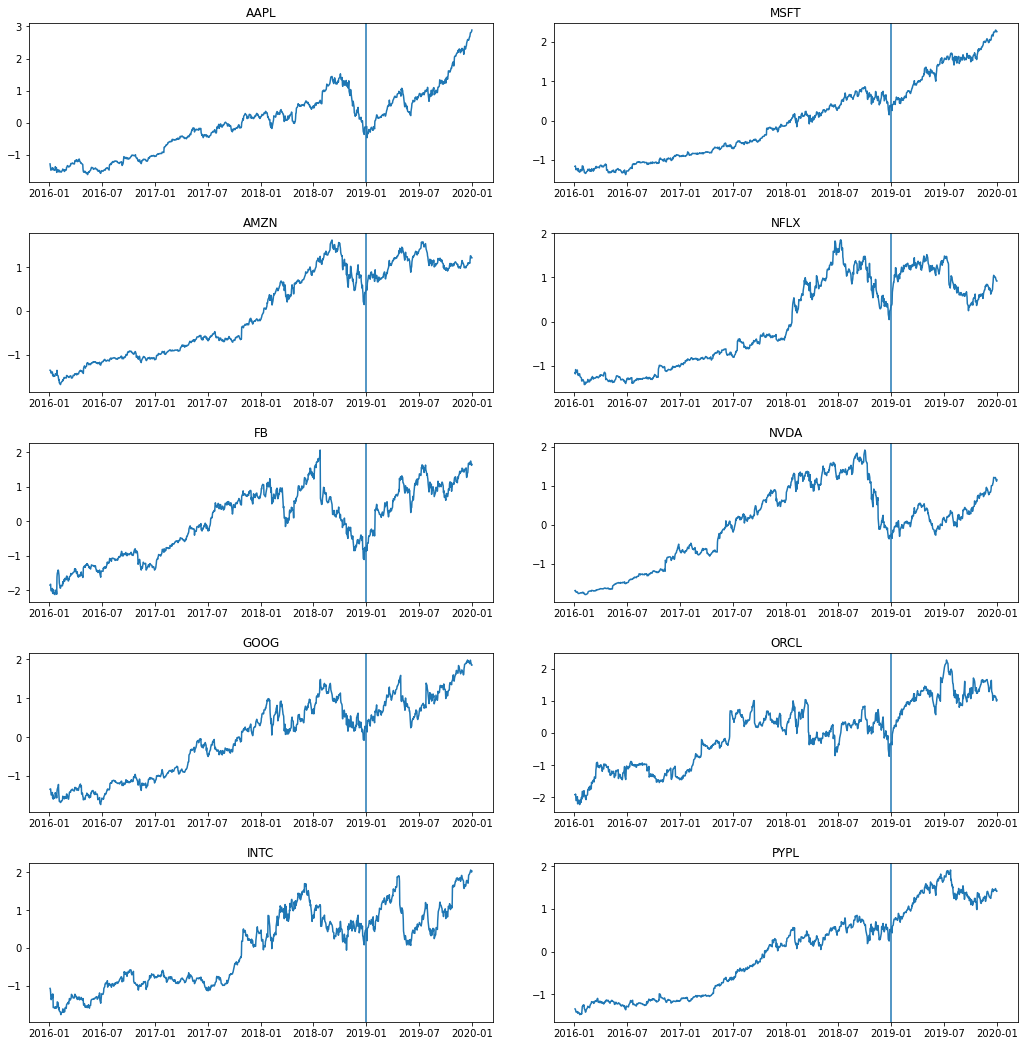

In [11]:
#Subplots of alls stocks
Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']

fig, axs = plt.subplots(5, 2,figsize=(15,15))
fig.tight_layout(pad=3.0)

for i in range(5):
    axs[i, 0].plot(NormPrices['PRC',Tick[i]])
    axs[i, 0].set_title(Tick[i])
    axs[i, 0].axvline(dt.datetime(2018, 12, 31))
    
for i in range(5):
    axs[i, 1].plot(NormPrices['PRC',Tick[i+5]])
    axs[i, 1].set_title(Tick[i+5])
    axs[i, 1].axvline(dt.datetime(2018, 12, 31))
    
#Added in line where test data will be split

In [12]:
#to check how many Nulls etc
#UnstackedPrices.info()

In [13]:
#TO examine values and distibutions/ make sure normalizaiton worked
#UnstackedPrices.describe()

# Feature Engineering Part 2

In [14]:
#Trimming data

NormPrices = NormPrices[:-2] #drop two rows, used to calculate returns
NormPrices = NormPrices[20:] #drop 20 rows, used to calculate volatility

#Restacking Data
NormPrices = MyStack(NormPrices)

#Adding day of week
NormPrices['WKDY'] = NormPrices['date'].dt.dayofweek 
NormPrices.reset_index(inplace=True, drop=True)

In [15]:
#Function to add lagged variables based on steps, and assembles data frame
def LagVar(X, steps):
    
    UnstackX = pd.pivot_table(X, values=['PRC','VOL', 'OPENPRC', 'WKDY', '5STD', '20STD', '5AVG'], index=['date'], columns=['TICKER'], aggfunc=np.sum)
    UnstackXTrim = UnstackX[steps:]
    UnstackXTrim  = MyStack(UnstackXTrim )
    UnstackXTrim.reset_index(inplace=True, drop=True)
    
    X = UnstackXTrim
    
    print(X)
    
    for i in range(steps):
 
        Shifted1 = UnstackX.shift(periods=i+1)
        Shifted1 = Shifted1[steps:]
        Shifted2 = Shifted1.stack(dropna=False)
        Shifted2.reset_index(inplace=True)
        Shifted2.sort_values(by=['TICKER', 'date'], inplace=True)
        Shifted2.reset_index(inplace=True, drop=True)
        Shifted3 = Shifted2.add_prefix(('Lag_' + str(i+1) + '_' ))
        Shifted3.drop([('Lag_' + str(i+1) + '_date' )], axis=1, inplace=True)
        Shifted3.drop([('Lag_' + str(i+1) + '_TICKER' )], axis=1, inplace=True)

        X = pd.concat([X, Shifted3], axis = 1)
    
    return(X)

In [16]:
Steps = 20

LagData = LagVar(NormPrices, Steps) 
LagData.reset_index(inplace=True, drop=True)
LagData.head() #Check for NaNs

           date TICKER     20STD      5AVG      5STD   OPENPRC       PRC  \
0    2016-03-02   AAPL -0.949866 -1.442339  0.020575 -1.383503 -1.378487   
1    2016-03-03   AAPL -0.820003 -1.421186  0.134390 -1.381952 -1.361907   
2    2016-03-04   AAPL -0.651341 -1.393963  0.165827 -1.342303 -1.328524   
3    2016-03-07   AAPL -0.597591 -1.370845 -0.704183 -1.341860 -1.353727   
4    2016-03-08   AAPL -0.569788 -1.368614 -0.773252 -1.377522 -1.372297   
...         ...    ...       ...       ...       ...       ...       ...   
9635 2019-12-20   PYPL  0.217513  1.442143 -0.496778  1.458711  1.439887   
9636 2019-12-23   PYPL  0.016892  1.434904 -0.787013  1.450072  1.434623   
9637 2019-12-24   PYPL  0.010165  1.436639 -0.778724  1.434672  1.437631   
9638 2019-12-26   PYPL  0.116213  1.451116 -0.713966  1.453077  1.477482   
9639 2019-12-27   PYPL  0.182575  1.455037 -0.661427  1.492029  1.464323   

           VOL  WKDY  
0     0.083629     2  
1     0.346220     3  
2     0.979455    

,date,TICKER,20STD,5AVG,5STD,OPENPRC,PRC,VOL,WKDY,Lag_1_20STD,...,Lag_19_PRC,Lag_19_VOL,Lag_19_WKDY,Lag_20_20STD,Lag_20_5AVG,Lag_20_5STD,Lag_20_OPENPRC,Lag_20_PRC,Lag_20_VOL,Lag_20_WKDY
0,2016-03-02,AAPL,-0.949866,-1.442339,0.020575,-1.383503,-1.378487,0.083629,2,-1.060131,...,-1.475762,0.973857,2.0,-0.735419,-1.513209,-0.272893,-1.496248,-1.517104,0.373413,1.0
1,2016-03-03,AAPL,-0.820003,-1.421186,0.134390,-1.381952,-1.361907,0.346220,3,-0.949866,...,-1.470235,1.004159,3.0,-0.843435,-1.500133,-0.446463,-1.505551,-1.475762,0.973857,2.0
2,2016-03-04,AAPL,-0.651341,-1.393963,0.165827,-1.342303,-1.328524,0.979455,4,-0.820003,...,-1.527273,1.000420,4.0,-0.894930,-1.488931,-0.659320,-1.486501,-1.470235,1.004159,3.0
3,2016-03-07,AAPL,-0.597591,-1.370845,-0.704183,-1.341860,-1.353727,0.273921,0,-0.651341,...,-1.505387,1.526539,0.0,-0.848087,-1.503748,-0.552465,-1.471882,-1.527273,1.000420,4.0
4,2016-03-08,AAPL,-0.569788,-1.368614,-0.773252,-1.377522,-1.372297,-0.027621,1,-0.597591,...,-1.505829,0.856008,1.0,-0.827745,-1.510085,-0.607858,-1.546972,-1.505387,1.526539,0.0


In [17]:
LagData.tail() #Check for NaNs if issue

,date,TICKER,20STD,5AVG,5STD,OPENPRC,PRC,VOL,WKDY,Lag_1_20STD,...,Lag_19_PRC,Lag_19_VOL,Lag_19_WKDY,Lag_20_20STD,Lag_20_5AVG,Lag_20_5STD,Lag_20_OPENPRC,Lag_20_PRC,Lag_20_VOL,Lag_20_WKDY
9635,2019-12-20,PYPL,0.217513,1.442143,-0.496778,1.458711,1.439887,0.428660,4,0.272737,...,1.177473,-0.390564,4.0,0.091243,1.260875,-0.176603,1.222823,1.206797,-0.128888,3.0
9636,2019-12-23,PYPL,0.016892,1.434904,-0.787013,1.450072,1.434623,-0.825028,0,0.217513,...,1.278228,0.067411,0.0,-0.065041,1.242552,0.309231,1.219818,1.177473,-0.390564,4.0
9637,2019-12-24,PYPL,0.010165,1.436639,-0.778724,1.434672,1.437631,-1.543048,1,0.016892,...,1.344019,1.231468,1.0,-0.209794,1.248508,0.421426,1.199534,1.278228,0.067411,0.0
9638,2019-12-26,PYPL,0.116213,1.451116,-0.713966,1.453077,1.477482,-0.970016,3,0.010165,...,1.402291,-0.122742,2.0,-0.124040,1.257934,0.917591,1.290434,1.344019,1.231468,1.0
9639,2019-12-27,PYPL,0.182575,1.455037,-0.661427,1.492029,1.464323,-1.131636,4,0.116213,...,1.412066,-0.874846,4.0,0.010420,1.285531,1.895143,1.368938,1.402291,-0.122742,2.0


# Target

In [18]:
#Setting up target (Use log returns?)

#Close price from next day
ClosePrc = UnstackedPrices.iloc[:,10:20].shift(periods=-1)
ClosePrc = ClosePrc[:-2]
ClosePrc = MyStack(ClosePrc)

#Open price from day after
OpenPrc = UnstackedPrices.iloc[:,:10].shift(periods=-2)
OpenPrc = OpenPrc[:-2]
OpenPrc = MyStack(OpenPrc)

#Add open price form day of trade


#Calculating Returns
OpenPrc['ClosePrc'] = ClosePrc['PRC']
OpenPrc['Returns'] = (OpenPrc['OPENPRC'] - OpenPrc['ClosePrc'])/OpenPrc['ClosePrc']

Returns = pd.DataFrame(OpenPrc['Returns'])
Returns.reset_index(inplace=True, drop=True)

array([[<AxesSubplot:title={'center':'Returns'}>]], dtype=object)

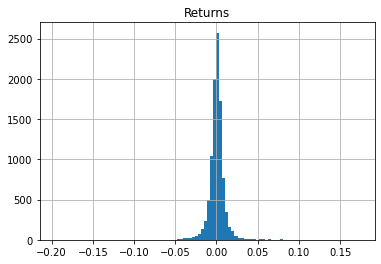

In [19]:
#Distribution of returns
Returns.hist(bins=100)

In [20]:
#Trim returns data based on lag steps
Returns = Returns[Steps:]
Returns.reset_index(inplace=True, drop=True)

#Add year for splitting based on year
LagData['YEAR'] = LagData['date'].dt.year

LagData['RET'] = Returns #Check if returns are matching up

# Splitting Data

In [21]:
#Splitting data, 2019 is test set

TestYear = 2019

X_train = LagData[LagData['YEAR'] != TestYear]
X_train.drop(['RET', 'YEAR', 'date', 'TICKER'], axis=1, inplace=True)

y_train = LagData[LagData['YEAR'] != TestYear]
y_train = y_train['RET']

X_test = LagData[LagData['YEAR'] == TestYear]
X_test.drop(['RET', 'YEAR', 'date', 'TICKER'], axis=1, inplace=True)

y_test = LagData[LagData['YEAR'] == TestYear]
y_test = y_test['RET']

In [22]:
#Total Average returns for equal weighted portfolio for test year
print("Equal Portfolio Returns for test year", TestYear, "=", round(y_test.sum()/10,4)*100, "%")

Equal Portfolio Returns for test year 2019 = 19.12 %


# Model Implementation (WIP)

In [23]:
from sklearn.model_selection import RandomizedSearchCV

#straight up copied the next 2 blocks

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 4)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [50, 100, 150, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 43, 76, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [24]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   1.7s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True, total=   1.5s
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total= 1.3min
[CV] n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=150, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total= 1.3min
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   2.7s
[CV] n_estimators=150, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=150, min

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 10.3min finished


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 43, 76, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 150, 200]},
                   random_state=42, verbose=2)

In [25]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [285]:
#Random Forest Regression Used this for developing backtesting
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

# Model Evaluation (WIP)

In [24]:
mean_squared_error(y_test, y_pred)

0.0001760808307211493

# Backtesting

In [286]:
#Setting up test data for backtesting

#Adding Prediction to test data
TestData = LagData[LagData['YEAR'] == TestYear]
TestData['PREDRET'] = regr.predict(X_test)

#Unstacking test data for backtesting
col = ['date', 'TICKER', 'RET', 'PREDRET']
XTrade = TestData[col]
XTrade = pd.pivot_table(XTrade, values=['RET', 'PREDRET'], index=['date'], columns=['TICKER'], aggfunc=np.sum)

#Setting up training data for backtesting optimization
TrainData = LagData[LagData['YEAR'] != TestYear]
TrainData['PREDRET'] = regr.predict(X_train)

#Unstacking train data for backtesting
col = ['date', 'TICKER', 'RET', 'PREDRET']
Xopt = TrainData[col]
Xopt = pd.pivot_table(Xopt, values=['RET', 'PREDRET'], index=['date'], columns=['TICKER'], aggfunc=np.sum)

In [297]:
#Backtesting function
def BackTest(X, Threshold):
    Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']
    
    for Tick in Tick:
        #Applying signal for each asset if threshold is passed
        
        #Add short signal and maybe strong sell and buy, increase portfolio weight
        X['SIGNAL', Tick] = 0
        mask = (X['PREDRET',Tick] > Threshold)
        X['SIGNAL', Tick][mask] = 1 # 1 = buy, 0 = do nothing
        X['TRADERET', Tick] = X['SIGNAL', Tick] * X['RET', Tick] #Calculating Returns based on signals

    X['HOLDINGS'] = X['SIGNAL'].sum(axis=1) #Number of assets bought each day, used to find average return
    X['TOTRET'] = (X['TRADERET'].sum(axis=1) / X['HOLDINGS']) #total returns by number of holding, this is portfolio returns
    X['TOTRET'] = X['TOTRET'].fillna(0) 

    X['CUMRET'] = X['TOTRET'].cumsum() +1 #Cummulative Returns
    X['ACTRET'] = X['RET'].sum(axis=1).cumsum()/10 +1 #Returns for equal position long portfolio
    
    #SharpeRatio = 
    
    return(X)

In [298]:
#optimizing threshold parameter based on training data
def BackTestOpt(X):

    lin = np.linspace(0, 0.001, 100)
    
    returns = []
    
    for i in lin:
        Y = BackTest(X, i)
        val = Y['CUMRET'][-1]
        returns.append(val)
    
    df = (pd.DataFrame([lin, returns])).T
    df.columns = ['Threshold','Returns']
    
    df['rollavg'] = df['Returns'].rolling(window=5).mean()
    
    idx = df['rollavg'].idxmax()
    val1 = df['Returns'][idx]
    val2 = df['Threshold'][idx]
    
    df.index = df['Threshold']
    df['Returns'].plot()
    df['rollavg'].plot()

    #peaks, _ = find_peaks(x, height=0)
    
    return(val1, val2)

0.00098


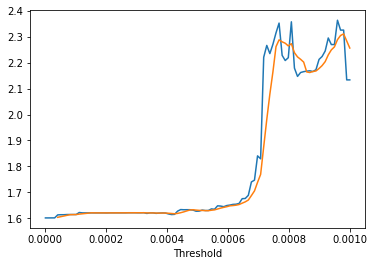

In [311]:
#Find optimal threshold
ret, thresh = BackTestOpt(Xopt)
print(round(thresh,5))

In [306]:
Threshold = 0.0008
#Threshold = thresh

#Backtest on test data with optimal or manual threshold
XTrade = BackTest(XTrade, Threshold)

# Trading Results

Text(0.5, 1.0, 'Model Portfolio vs Equal Portfolio Returns')

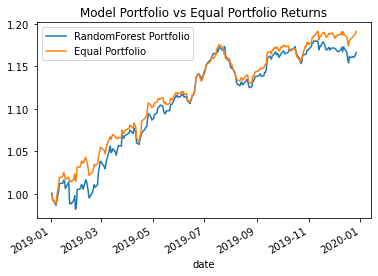

In [307]:
XTrade['CUMRET'].plot()
XTrade['ACTRET'].plot()
plt.legend(['RandomForest Portfolio', 'Equal Portfolio'], loc="upper left")
plt.title('Model Portfolio vs Equal Portfolio Returns')

In [ ]:
#Add some more visuals and results...

In [ ]:
#White's Reality Check
def WRC():
    
    return()